# NYC Ticket Writing Machine!
### DS4400 Final Project
### by Benjamin Kosiborod and Victoria Staada
&nbsp;
## Data Cleanup

In [1]:
# All project imports
import pandas as pd
import numpy as np
import math
import datetime
import re
from matplotlib import pyplot as plt
import seaborn as sns
import time

from keras.utils import np_utils
import keras.callbacks as cb
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, MaxPooling3D
from keras.optimizers import RMSprop
from keras.datasets import mnist

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_fscore_support, multilabel_confusion_matrix

In [2]:
# Read in the data
data = pd.read_csv('https://data.cityofnewyork.us/resource/faiq-9dfq.csv?$limit=12000000')

/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (17,18,20,22,23,29,30,31,32,36,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Copy the data so that we can
# manipulate the data and re-copy
# if we make a mistake
df = data.copy()

In [4]:
# Preview the data
print(df.describe())

       summons_number  violation_code  street_code1  street_code2  \
count    1.146751e+07    1.146751e+07  1.146751e+07  1.146751e+07   
mean     7.474217e+09    3.377908e+01  2.562781e+04  2.119624e+04   
std      2.268085e+09    1.985783e+01  2.246802e+04  2.193509e+04   
min      1.028884e+09    0.000000e+00  0.000000e+00  0.000000e+00   
25%      8.500714e+09    2.000000e+01  9.130000e+03  0.000000e+00   
50%      8.655880e+09    3.600000e+01  1.934000e+04  1.474000e+04   
75%      8.694870e+09    4.000000e+01  3.618000e+04  3.427000e+04   
max      8.768851e+09    9.900000e+01  9.802000e+04  9.831000e+04   

       street_code3  vehicle_expiration_date  violation_location  \
count  1.146751e+07             1.146751e+07        9.589591e+06   
mean   2.126681e+04             2.691894e+07        5.636025e+01   
std    2.198500e+04             2.736702e+07        3.963513e+01   
min    0.000000e+00             0.000000e+00        1.000000e+00   
25%    0.000000e+00             2.0181

In [5]:
# Drop some columns that are mostly empty, 
# or do not have useful data
df = df.drop(columns=['violation_post_code', 'violation_location', 'feet_from_curb', 'house_number', 'intersecting_street', 'date_first_observed', 'law_section', 'sub_division', 'violation_legal_code', 'violation_in_front_of_or', 'time_first_observed', 'issuer_code', 'issuer_command', 'issuer_squad', 'summons_number', 'plate_id', 'days_parking_in_effect', 'from_hours_in_effect', 'to_hours_in_effect', 'unregistered_vehicle', 'violation_description', 'no_standing_or_stopping', 'hydrant_violation', 'double_parking_violation'])

In [6]:
# Check columns left and their types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11467506 entries, 0 to 11467505
Data columns (total 19 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   registration_state       object
 1   plate_type               object
 2   issue_date               object
 3   violation_code           int64 
 4   vehicle_body_type        object
 5   vehicle_make             object
 6   issuing_agency           object
 7   street_code1             int64 
 8   street_code2             int64 
 9   street_code3             int64 
 10  vehicle_expiration_date  int64 
 11  violation_precinct       int64 
 12  issuer_precinct          int64 
 13  violation_time           object
 14  violation_county         object
 15  street_name              object
 16  vehicle_color            object
 17  vehicle_year             int64 
 18  meter_number             object
dtypes: int64(8), object(11)
memory usage: 1.6+ GB
None


In [7]:
# Instead of having meter numbers, change this column into a boolean value
# for meter or no meter recorded at time of violation
df['meter_number'] = df['meter_number'].apply(lambda x: 0 if x == '-' or pd.isnull(x) else 1)
df = df.rename({'meter_number': 'meter?'}, axis=1)

In [8]:
colors = {}
for color in ('WH', 'W', 'w', 'white', 'White', 'WT', 'WHI', 'WH/', 'WHITE', 'Cream', 'CREAM', 'WT.', 'WHTE', 'WH YW', 'WHITW', 'HT', 'WHT', 'WHBL', 'WHB', 'WHO', 'WHGY', 'WHIT', 'WHG', 'WHRD', 'WHGR', 'WTE', 'WH.', 'WHBK', 'WHTN', 'WHT.', 'WHTIE', 'WHE', 'WHGL', 'W/B', 'CRM', 'WHBR', 'WHWH', 'WHOR', 'WG', 'WHYW', 'WHIE', 'WJ', 'WHLE'):
    colors[color] = 'White'
for color in ('Black', 'BLK', 'BK', 'black', 'BLK.', 'BK.', 'BLACK', 'BLW', 'BKGY', 'BK/', 'BKBL', 'BLCK', 'BKGR', 'BLWH', 'BLA', 'BKG', 'BLK.', 'BKTN', 'BKW', 'BKT', 'BKWH', 'BLAC', 'BLAK', 'BLTN', 'BLRD', 'BKBK', 'BLGL', 'BLKWH'):
    colors[color] = 'Black'
for color in ('GRY', 'Gray', 'GY/', 'GRAY', 'GY', 'GREY', 'grey', 'Grey', 'DKGRY', 'M.GRE', 'GY/GL', 'GRAYF', 'CHRAY', 'LTGY', 'DKGY', 'GYGY', 'GYBL', 'GYGR', 'GY.', 'GYB', 'GRA', 'GYRD', 'GYBK', 'GYTN', 'GYG', 'GYBR', 'GYWH', 'GRY.', 'GRAY.', 'ALUMI', 'GYT', 'GREY.', 'GYGL', 'Gray', 'GYPR', 'GY GR'):
    colors[color] = 'Gray'
for color in ('Silver', 'SILVER', 'SLV', 'SV', 'SL', 'SILV', 'SILVE', 'SIL', 'SILVR', 'SL.', 'STEEL', 'MET', 'SLVR', 'SLR', 'SIV', 'SLVER', 'SLIVE', 'SLVE', 'SIL.'):
    colors[color] = 'Silver'
for color in ('TAN', 'Beige', 'BEIGE', 'beige', 'BLD', 'ALMON', 'TN', 'LTTN', 'TNGY', 'BE', 'BIEGE', 'TNGR', 'DKTN', 'TN/', 'BEIG'):
    colors[color] = 'Beige'
for color in ('RED', 'red', 'RD', 'rd', 'Rd', 'Red', 'RO', 'BUGA', 'MAROO', 'MAR', 'MR', 'BUNGE', 'RDW', 'DKR', 'DKRD', 'RD/', 'BURG', 'BURGU', 'BUR', 'RDGY', 'RD.', 'RDT', 'RDBK', 'RDBL', 'MRPK', 'RDG', 'RDGR', 'RDWH', 'RDRD', 'RDTN', 'DKMR', 'RD BK', 'RED.', 'BURGA', 'MRGY', 'MRN', 'BUG', 'RE', 'RDBR', 'DKRED'):
    colors[color] = 'Red'
for color in ('BLUE', 'BL', 'BLLU', 'QBLUE', 'BUO', 'BLU', 'DKBL', 'BLG', 'BL/', 'BLGY', 'LTBL', 'BLGR', 'BLBL', 'DBL', 'BL.', 'BLB', 'LBL', 'BLBK', 'BLUE.', 'NAVY', 'BLRD'):
    colors[color] = 'Blue'
for color in ('GREEN', 'GR', 'GYN', 'GRN', 'LTGR', 'DKGR', 'GR/', 'GRE', 'GRGY', 'GRG', 'GRW', 'GRBL', 'GRGR', 'DGR', 'GRB', 'GREN', 'GRT', 'LGR', 'GREE', 'GRTN'):
    colors[color] = 'Green'
for color in ('YELLW', 'YEL', 'YELL', 'YELLO', 'YW', 'GOLDE', 'ORO', 'YOL', 'YLOW', 'YL', 'GL', 'GOLD', 'GLD', 'YLW', 'Y', 'YE', 'YLLW', 'YELLL'):
    colors[color] = 'Yellow'
for color in ('BROWN', 'BR', 'BR/GY', 'BON', 'BRWMN', 'BREIR', 'BEUG', 'BRWN', 'BRN', 'BRO', 'BRW', 'BWN', 'LTBR', 'BROW', 'BRZ', 'DKBR', 'BRBL', 'BRON', 'BRT'):
    colors[color] = 'Brown'
for color in ('LAVEN', 'PURPL', 'PR', 'PURP', 'PUR', 'DKRR'):
    colors[color] = 'Purple'
for color in ('OR', 'ORANGE', 'ORANG', 'ONG', 'O', 'OG', 'ORA', 'ORAN', 'ORWH', 'ORN'):
    colors[color] = 'Orange'

df['vehicle_color'] = df['vehicle_color'].apply(lambda row: colors.get(row, row))

# Drop rows that are not categorized by the above, 
# as there as <500K such records out of 11.5M
# and the colors begin to get more niche. We
# suspect there is not enough data to accurately
# make predictions for the remaining colors.
df = df[df.vehicle_color.isin(colors.values())]

In [9]:
df = df[(df.vehicle_year <= 2020) & (df.vehicle_year != 0)]

In [10]:
# Get rid of null and non-stated vehicle makes, 
# as well as rows that contain makes where 
# there are less than 100 records
df = df[pd.notnull(df.vehicle_make) 
        & (df.vehicle_make != 'NS/OT') 
        & (df.vehicle_make != 'FRE') 
        & (df.vehicle_make != 'STARC')
        & (df.vehicle_make != 'BL/BI')
        & (df.vehicle_make != 'COLLI')
        & (df.vehicle_make != 'UNIFL')
        & (df.vehicle_make != 'ORION')
        & (df.vehicle_make != 'TSM')
        & (df.vehicle_make != 'EASTO')]
df = df.groupby('vehicle_make').filter(lambda x: len(x) > 100)

makes = {
    'FORD': 'Ford',
    'TOYOT': 'Toyota',
    'HONDA': 'Honda',
    'NISSA': 'Nissan',
    'CHEVR': 'Chevrolet',
    'ME/BE': 'Mercedes-Benz',
    'FREUH': 'Fruehauf',
    'DODGE': 'Dodge',
    'HYUND': 'Hyundai',
    'JEEP': 'Jeep',
    'LEXUS': 'Lexus',
    'INTER': 'International Harvester',
    'ACURA': 'Acura',
    'INFIN': 'Infiniti',
    'SUBAR': 'Subaru',
    'VOLKS': 'Volkswagen',
    'HIN': 'Hindustan Motors',
    'CHRYS': 'Chrystler',
    'AUDI': 'Audi',
    'ISUZU': 'Isuzu',
    'KIA': 'Kia',
    'MAZDA': 'Mazda',
    'MITSU': 'Mitsubishi',
    'ROVER': 'Land Rover',
    'CADIL': 'Cadillac',
    'LINCO': 'Lincoln',
    'VOLVO': 'Volvo',
    'WORKH': 'Workhorse',
    'KENWO': 'Kenworth',
    'BUICK': 'Buick',
    'SMART': 'smart',
    'PETER': 'Peterbilt',
    'MINI': 'Mini',
    'PORSC': 'Porsche',
    'MERCU': 'Mercury',
    'JAGUA': 'Jaguar',
    'FIAT': 'Fiat',
    'SATUR': 'Saturn',
    'PONTI': 'Pontiac',
    'UTILI': 'Utility',
    'MACK': 'Mack',
    'TESLA': 'Tesla',
    'SUZUK': 'Suzuki',
    'UD': 'UD Trucks',
    'MASE': 'Maserati',
    'SAAB': 'Saab',
    'HYUN': 'Hyundai',
    'HUMME': 'Hummer',
    'OLDSM': 'Oldsmobile',
    'MCI': 'Motor Coach Industries',
    'THOMA': 'Thomas Built Busses',
    'IC': 'IC Bus',
    'YAMAH': 'Yamaha',
    'BENTL': 'Bentley',
    'VANHO': 'Van Hool Bus',
    'SPRI': 'Springdale RVs',
    'KAWAS': 'Kawasaki',
    'ALFAR': 'Alfa Romeo',
    'PLYMO': 'Plymouth',
    'HARLE': 'Harley Davidson',
    'STERL': 'Sterling',
    'VESPA': 'Vespa',
    'UPS': 'UPS Truck',
    'VPG': 'Vehicle Production Group',
    'PREVO': 'Prevost RVs',
    'GEO': 'Geo',
    'NAVIS': 'Navistar',
    'FERRA': 'Ferrari',
    'TRIUM': 'Triumph',
    'DUCAT': 'Ducati',
    'ZENIT': 'Zenith',
    'GENES': 'Genesis',
    'SCION': 'Scion',
    'HINO': 'Hino Motors',
    'ROLLS': 'Rolls Royce',
    'LAMBO': 'Lamborgini',
    'CHECK': 'Checker Motors',
    'SETRA': 'Setra Coach',
    'ACUR': 'Acura',
    'GREAT': 'Great Dane',
    'LEXU': 'Lexus',
    'SMITH': 'Smith Electric Vehicles',
}

df['vehicle_make'] = df['vehicle_make'].apply(lambda row: makes.get(row, row))

In [11]:
# clean up violation county
counties = {
    'NY': 'Manhattan',
    'K': 'Brooklyn',
    'Q': 'Queens',
    'BX': 'Bronx',
    'BK': 'Brooklyn',
    'QN': 'Queens',
    'R': 'Staten Island',
    'ST': 'Staten Island',
    'MN': 'Manhattan',
    'QUEEN': 'Queens',
}
df['violation_county'] = df['violation_county'].apply(lambda row: counties.get(row, row))

In [12]:
# clean up registration state
df = df[pd.notnull(df.registration_state) & (df.registration_state != '99')]
state = {
    'GV': 'U.S. Government',
    'DP': 'U.S. Department of State',
}
df['registration_state'] = df['registration_state'].apply(lambda row: state.get(row, row))

In [13]:
df = df[pd.notnull(df.plate_type) & (df.plate_type != '999')]
df = df.groupby('plate_type').filter(lambda x: len(x) > 100)
plate_types = {
    'PAS': 'Passenger',
    'COM': 'Commercial',
    'OMT': 'Taxi Omnibus',
    'OMS': 'Special Omnibus Rentals',
    'SRF': 'Special Passenger',
    'APP': 'Apportioned',
    'TRC': 'Tractor',
    'ORG': 'Organizational',
    'OMR': 'Omnibus',
    'MED': 'Medical Doctor',
    'SPO': 'Sports Passenger',
    'OML': 'Livery Omnibus',
    'PSD': 'Political Subdivision',
    'SCL': 'School Car',
    'IRP': 'International Reg Plan',
    'TOW': 'Tow Truck',
    'MOT': 'Motorcycle',
    'RGL': 'Regional',
    'VAS': 'Volunteer Ambulance Services',
    'ITP': 'In Transit Permit',
    'SRN': 'Special Passenger Judges/Officials',
    'HIS': 'Historical',
    'TRA': 'Transporter',
    'CHC': 'Household Carrier Commercial',
    'STA': 'State Agencies',
    'AGR': 'Agricultural',
    'AMB': 'Ambulance',
    'PHS': 'Pearl Harbor Survivors',
    'AYG': 'Army National Guard',
    'RGC': 'Regional Commercial',
    'ORC': 'Organizational Commercial',
    'TRL': 'Regular Trailer',
    'HAM': 'HAM Operator',
    'DLR': 'Dealer',
}
df['plate_type'] = df['plate_type'].apply(lambda row: plate_types.get(row, row))

In [14]:
# Clean up issue date, get rid of dates not in 2019 fiscal year
# (includes 2018 and 2019 issue dates)
df.issue_date = pd.to_datetime(df['issue_date'], errors='coerce')
df = df[df.issue_date.dt.year.isin([2018, 2019])]

In [15]:
# Clean up vehicle body type, get rid of null or unknown
# body types, and the least popular ones.
df = df[pd.notnull(df.vehicle_body_type) 
        & (df.vehicle_body_type != 'OLNE')
        & (df.vehicle_body_type != 'LL')
        & (df.vehicle_body_type != 'APUR')
        & (df.vehicle_body_type != 'CW')
        & (df.vehicle_body_type != 'O')
        & (df.vehicle_body_type != 'EP')
        & (df.vehicle_body_type != 'OM')]
df = df.groupby('vehicle_body_type').filter(lambda x: len(x) > 100)
body_types = {
    'SUBN': 'Suburban',
    '4DSD': '4 Door Sedan',
    'VAN': 'Van',
    'DELV': 'Delivery',
    'PICK': 'Pickup Truck',
    '2DSD': '2 Door Sedan',
    'SDN': 'Sedan',
    'REFG': 'Refridgerated',
    'UTIL': 'Utility',
    'TAXI': 'Taxi',
    '4 DR': '4 Door',
    '4D': '4 Door',
    'TRAC': 'Tractor',
    'CONV': 'Convertible',
    'WAGO': 'Wagon',
    'BUS': 'Bus',
    'FLAT': 'Flatbed Truck',
    'P-U': 'Pickup Truck',
    'DUMP': 'Dump Truck',
    'UT': 'Utility',
    'MCY': 'Motorcycle',
    'TRK': 'Truck',
    '4W': '4 Door Wagon',
    'TOW': 'Tow Truck',
    'PKUP': 'Pickup Truck',
    '4S': '4 Door Sedan',
    'SU': 'Sport Utility Vehicle',
    'STAK': 'Stake Truck',
    '2 DR': '2 Door',
    'MP': 'Moped',
    'VN': 'Van',
    'TANK': 'Tank Truck',
    'SW': 'Station Wagon',
    'FOUR': '4 Door',
    'SEDN': 'Sedan',
    'TK': 'Truck',
    '2D': '2 Door',
    'SD': 'Sedan',
    'PK': 'Pickup Truck',
    'SV': 'Sports Van',
    '4H': '4 Door Hatchback',
    'TR/C': 'Truck Crane',
    'CON': 'Convertible',
    'TRUC': 'Truck',
    'LIM': 'Limousine',
    'CP': 'Coupe',
    'SEDA': 'Sedan',
    '4DOO': '4 Door',
    '5D': '5 Door',
    'SWT': 'Small-Wheel Truck',
    'CV': 'Convertible',
    'H/WH': 'Motorhome',
    'CMIX': 'Cement Mixer',
    '4DSE': '4 Door Sedan',
    'TWOD': '2 Door',
    'TRL': 'Trailer',
    'MC': 'Motorcycle',
    'REF': 'Refridgerated',
    'TT': 'Tractor Trailer',
    'TRC': 'Tractor',
    'TRLR': 'Trailer',
    'BOAT': 'Boat Trailer',
    'ES': 'Station Wagon',
    'TRAI': 'Trailer',
    'TR': 'Truck',
    '2S': '2 Door Sedan',
    'HRSE': 'Hearse',
    'TLR': 'Trailer',
    'SPOR': 'Sports Car',
    'SUV': 'SUV',
    'MOT': 'Motorcycle',
    '2H': '2 Door Hatchback',
    'SUBU': 'Suburban',
    'TRT': 'Tractor Trailer',
    'LIMO': 'Limousine',
}
df['vehicle_body_type'] = df['vehicle_body_type'].apply(lambda row: body_types.get(row, row))

In [16]:
# Each street can be encoded with a 5-digit street code
# Each ticket has 3 street codes, because street code 1 
# denotes the "on" street, while street codes 2 & 3
# denote the "cross" steets. For example, Lexington Ave
# between E 42nd and E 45th is a location, where the 
# car was parked on Lexington Ave, between E 42nd and E 45th streets.
# See below link for more detail:
# https://nycplanning.github.io/Geosupport-UPG/chapters/chapterVII/section03/
df = df[(df.street_code1 != 0) & (pd.notnull(df.street_code1))
   & (df.street_code2 != 0) & (pd.notnull(df.street_code2))
   & (df.street_code3 != 0) & (pd.notnull(df.street_code3))]

In [17]:
df = df[(df.vehicle_expiration_date != 0) & (df.vehicle_expiration_date != 88880088)]
df.vehicle_expiration_date = pd.to_datetime(df['vehicle_expiration_date'], format='%Y%m%d',errors='coerce')

In [18]:
# Clean up violation codes. 
# 1-99 are valid codes.
df = df[(df.violation_code > 0) & (df.violation_code < 100)]

In [19]:
# Clean up violation & issuer precincts, 
# get rid of invalid precinct numbers
valid_precincts = [1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 
                   32, 33, 34, 40, 41, 42, 43, 44, 45, 46,47, 48, 49, 50, 52, 60, 61, 
                   62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 83, 
                   84, 88, 90, 94, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 
                   110, 111, 112, 113, 114, 115, 120, 121, 122, 123]
df = df[df.violation_precinct.isin(valid_precincts)]
df = df[df.issuer_precinct.isin(valid_precincts)]

In [20]:
# Clean up violation time by removing
# NaNs and restricting rows to only those that
# match the regex pattern given. This allows
# us to standardize the time format to a 12-hour
# format with "A" or "P" at the end, denoting AM/PM
df = df[(pd.notnull(df.violation_time)) & (df.violation_time.str.contains('(1[012]|0[1-9])[0-5][0-9](A|P)', regex=True, na=False))]
df.violation_time = df.violation_time.apply(lambda row: float(row[:-1]) if row[4] == 'A' else float(row[:-1])+1200)
df.violation_time = df.violation_time.apply(lambda row: row - 2400 if row / 2400 >= 1 else row)

/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [21]:
# Finally, drop all rows where NaN values exist
df = df.dropna()

# Reset the index so that the DataFrame is easier to work with
df = df.reset_index().drop(columns=['index'])

In [22]:
# Due to our poor initial results, we considered dropping some of the least
# popular violation codes, to try to reduce the number of classes to predict.

# Initially, we tried dropping all violation codes with less than 1,000 instances.
# This did not improve our results, so we tried dropping all violation codes with
# less than 10,000 instances. This did not improve our results either, so we stopped
# the experiment, but felt it would be valuable to leave this code here anyways.

# good_vcodes = list(df.violation_code.value_counts().head(29).index)
# df_clean_vcodes = df[df.violation_code.isin(good_vcodes)]

In [61]:
# Limit to sample of 100K for training
data = df.sample(n=100000)

In [62]:
# Get features and target
# Dropping street name because we will use it as a reference
# Rather than a feature for training
features = data.drop(columns=["violation_code", "street_name"])
target = data.violation_code

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

# Encode features
encoded_columns = ['registration_state', 'plate_type', 'vehicle_body_type', 'vehicle_make', 'issuing_agency', 'violation_county', 'vehicle_color']
categories = [features[column].unique() for column in encoded_columns]
encoder = OrdinalEncoder(categories=categories).fit(X_train[encoded_columns])

X_train_enc = X_train.copy()
X_test_enc = X_test.copy()
X_train_enc[encoded_columns] = encoder.transform(X_train[encoded_columns])
X_test_enc[encoded_columns] = encoder.transform(X_test[encoded_columns])

# Encode Datetime
datetime_columns = ['issue_date', 'vehicle_expiration_date']
X_train_enc[datetime_columns] = X_train_enc[datetime_columns].astype(int)
X_test_enc[datetime_columns] = X_test_enc[datetime_columns].astype(int)

X_train, X_test = X_train_enc.to_numpy(), X_test_enc.to_numpy()

In [63]:
# Look for outliers
iforest = IsolationForest().fit(X_train)
train_outliers = iforest.predict(X_train)
test_outliers = iforest.predict(X_test)

train_non_outliers = train_outliers != -1
test_non_outliers = test_outliers != -1

X_train, y_train = X_train[train_non_outliers, :], y_train[train_non_outliers]
X_test, y_test = X_test[test_non_outliers, :], y_test[test_non_outliers]

In [64]:
def metrics(y_train, y_pred_train, y_test, y_pred_test, classifier_name):
    '''Prints classification metrics for the given classifier_name
       Input: y_true and y_predicted for both training and testing, as well as classifier name as a string
       Output: None, prints report of accuracy metrics as well as classification report'''
    print(f"{classifier_name}:")
    print("\tTraining:")
    print("\t\tAccuracy:", accuracy_score(y_train, y_pred_train))
    print("\t\tError:", 1-accuracy_score(y_train, y_pred_train))
    print("\t\tClassification Report:")
    print(classification_report(y_train, y_pred_train))
    print("\tTesting:")
    print("\t\tAccuracy:", accuracy_score(y_test, y_pred_test))
    print("\t\tError:", 1-accuracy_score(y_test, y_pred_test))
    print("\t\tClassification Report:")
    print(classification_report(y_test, y_pred_test))
    print("\t\tMultilabel Confusion Matrix:")
    print(multilabel_confusion_matrix(y_test, y_pred_test, labels=sorted(pd.Series(y_test).unique())))

kNN Classifier:
	Training:
		Accuracy: 0.39470087593961606
		Error: 0.605299124060384
		Classification Report:
              precision    recall  f1-score   support

           1       0.20      1.00      0.33         1
           4       0.25      1.00      0.40         1
           8       0.16      0.53      0.25        30
          10       0.19      0.53      0.28       353
          11       0.21      0.59      0.31        63
          13       0.17      0.41      0.24       143
          14       0.26      0.57      0.36      4852
          16       0.24      0.36      0.29      2163
          17       0.23      0.27      0.25       837
          18       0.19      0.20      0.19       290
          19       0.24      0.27      0.25      1545
          20       0.33      0.41      0.37      5835
          21       0.46      0.61      0.52     12499
          22       0.12      0.03      0.05        35
          23       0.00      0.00      0.00         6
          24       0.36 

/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

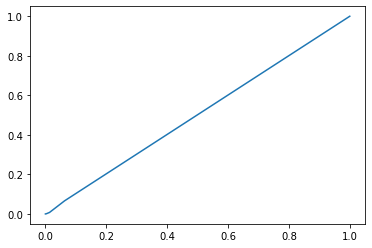

In [65]:
# Train, test, and evaluate kNN
knn = KNeighborsClassifier().fit(X_train, y_train)

y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

metrics(y_train, y_pred_train, y_test, y_pred_test, 'kNN Classifier')

y_score = knn.predict_proba(X_test)
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(pd.Series(y_train).unique())):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=pd.Series(y_train).unique())[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(y_test, classes=pd.Series(y_train).unique()).ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average kNN curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

Decision Tree:
	Training:
		Accuracy: 0.5079362614151706
		Error: 0.49206373858482944
		Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           8       0.43      0.10      0.16        30
          10       0.49      0.28      0.36       353
          11       0.79      0.17      0.29        63
          13       0.78      0.37      0.50       143
          14       0.50      0.38      0.43      4852
          16       0.54      0.26      0.35      2163
          17       0.67      0.14      0.22       837
          18       0.69      0.24      0.35       290
          19       0.55      0.12      0.19      1545
          20       0.55      0.39      0.46      5835
          21       0.60      0.88      0.71     12499
          22       0.60      0.09      0.15        35
          23       1.00      0.17      0.29         6
          24       0.43 

/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

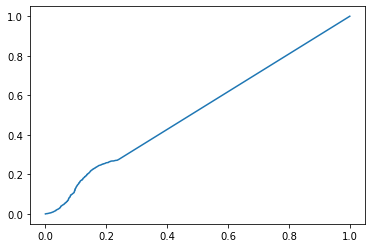

In [66]:
# Train, test, and evaluate Decision Tree
tree = DecisionTreeClassifier(max_depth=13).fit(X_train, y_train)

y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

metrics(y_train, y_pred_train, y_test, y_pred_test, 'Decision Tree')

y_score = tree.predict_proba(X_test)
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(pd.Series(y_train).unique())):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=pd.Series(y_train).unique())[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(y_test, classes=pd.Series(y_train).unique()).ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot all ROC curves
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average Decision Tree curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

Random Forest:
	Training:
		Accuracy: 0.9999378766229732
		Error: 6.212337702682369e-05
		Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           8       1.00      1.00      1.00        30
          10       1.00      1.00      1.00       353
          11       1.00      1.00      1.00        63
          13       1.00      1.00      1.00       143
          14       1.00      1.00      1.00      4852
          16       1.00      1.00      1.00      2163
          17       1.00      1.00      1.00       837
          18       1.00      1.00      1.00       290
          19       1.00      1.00      1.00      1545
          20       1.00      1.00      1.00      5835
          21       1.00      1.00      1.00     12499
          22       1.00      1.00      1.00        35
          23       1.00      1.00      1.00         6
          24       1.0

/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kos

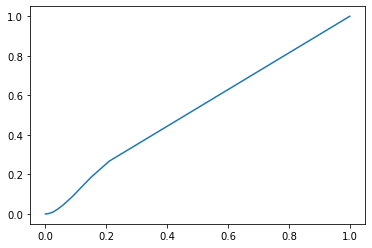

In [67]:
# Train, test, and evaluate Random Forest
rforest = RandomForestClassifier().fit(X_train, y_train)

y_pred_train = rforest.predict(X_train)
y_pred_test = rforest.predict(X_test)

metrics(y_train, y_pred_train, y_test, y_pred_test, 'Random Forest')

y_score = rforest.predict_proba(X_test)
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(pd.Series(y_train).unique())):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=pd.Series(y_train).unique())[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(y_test, classes=pd.Series(y_train).unique()).ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot all ROC curves
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average Random Forest curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

AdaBoost:
	Training:
		Accuracy: 0.5630862893706902
		Error: 0.43691371062930984
		Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           8       1.00      0.77      0.87        30
          10       0.78      0.57      0.66       353
          11       1.00      0.62      0.76        63
          13       1.00      0.64      0.78       143
          14       0.49      0.54      0.52      4852
          16       0.62      0.41      0.49      2163
          17       0.74      0.35      0.48       837
          18       0.98      0.49      0.65       290
          19       0.64      0.41      0.50      1545
          20       0.48      0.56      0.52      5835
          21       0.64      0.67      0.66     12499
          22       1.00      0.86      0.92        35
          23       1.00      1.00      1.00         6
          24       1.00      

/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kosiborod.b/.conda/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

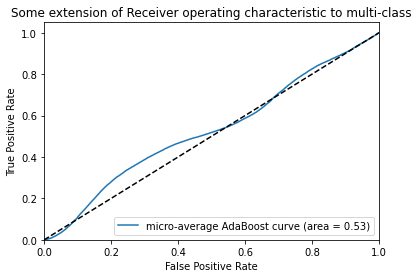

In [69]:
# Define base classifier for AdaBoost.
# Decision Tree w/max_depth=13 worked the best so far...

# Train, test, and evaluate AdaBoost
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=13)).fit(X_train, y_train)

y_pred_train = ada.predict(X_train)
y_pred_test = ada.predict(X_test)

metrics(y_train, y_pred_train, y_test, y_pred_test, 'AdaBoost')

y_score = ada.predict_proba(X_test)
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(pd.Series(y_train).unique())):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=pd.Series(y_train).unique())[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(y_test, classes=pd.Series(y_train).unique()).ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot all ROC curves
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average AdaBoost curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [31]:
def init_model():
    '''Multilayer perceptron definition. H/T Alina Oprea'''
    start_time = time.time()

    print("Compiling Model")
    model = Sequential()
    # 17 features
    model.add(Dense(500, input_dim=17))
    model.add(Activation('sigmoid'))
    model.add(Dense(250))
    model.add(Activation('sigmoid'))
    # 99 different output classes
    model.add(Dense(99))
    model.add(Activation('softmax'))

    rms = RMSprop()
    model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])
    
    print(f"Model finished in: {time.time() - start_time}")
    return model

def run_network(model=None, epochs=20, batch=256):
    '''Run the neural network. H/T Alina Oprea'''
    start_time = time.time()
    
    print("Training model")
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_data=(X_test, y_test), verbose=2)

    print(f"Training duration: {time.time() - start_time}")
    score = model.evaluate(X_test, y_test, batch_size=16)

    print(f"\nNetwork's test loss and accuracy duration: {time.time() - start_time}")
    return history

def plot_losses(hist):
    '''Plot metrics of the neural network. H/T Alina Oprea'''
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

Compiling Model
Model finished in: 2.725717782974243
Training model
Epoch 1/100
256/256 - 3s - loss: 2.7086 - accuracy: 0.1953 - val_loss: 2.6642 - val_accuracy: 0.1981
Epoch 2/100
256/256 - 1s - loss: 2.6313 - accuracy: 0.2220 - val_loss: 2.6231 - val_accuracy: 0.2331
Epoch 3/100
256/256 - 1s - loss: 2.6139 - accuracy: 0.2272 - val_loss: 2.6078 - val_accuracy: 0.2331
Epoch 4/100
256/256 - 1s - loss: 2.6080 - accuracy: 0.2292 - val_loss: 2.6212 - val_accuracy: 0.2331
Epoch 5/100
256/256 - 1s - loss: 2.6051 - accuracy: 0.2317 - val_loss: 2.6080 - val_accuracy: 0.2331
Epoch 6/100
256/256 - 1s - loss: 2.6026 - accuracy: 0.2298 - val_loss: 2.6111 - val_accuracy: 0.2331
Epoch 7/100
256/256 - 1s - loss: 2.6011 - accuracy: 0.2322 - val_loss: 2.6035 - val_accuracy: 0.2331
Epoch 8/100
256/256 - 1s - loss: 2.5993 - accuracy: 0.2316 - val_loss: 2.6013 - val_accuracy: 0.2331
Epoch 9/100
256/256 - 1s - loss: 2.5983 - accuracy: 0.2322 - val_loss: 2.5992 - val_accuracy: 0.2331
Epoch 10/100
256/256 - 

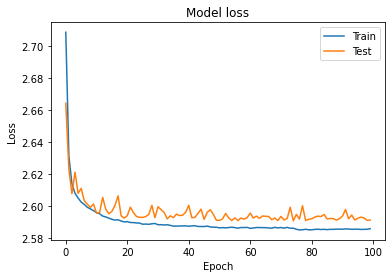

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               9000      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 99)                24849     
_________________________________________________________________
activation_2 (Activation)    (None, 99)                0         
Total params: 159,099
Trainable params: 159,099
Non-trainable params: 0
__________________________________________________

In [32]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

nn_model = init_model()
history = run_network(model = nn_model, epochs=100)
plot_losses(history)
nn_model.summary()